In [31]:
# load data
import pandas as pd
from preprocess import get_maneuvers

data = pd.read_csv('data/preprocessed/41335.csv', parse_dates=['EPOCH'])
maneuvers = get_maneuvers('41335')
maneuvers = [i for i in maneuvers if i > data['EPOCH'][0]]

# break out datetime into year, month, day, day of week, hour
data['YEAR'] = data['EPOCH'].dt.year
data['MONTH'] = data['EPOCH'].dt.month
data['DAY'] = data['EPOCH'].dt.day
data['WEEKDAY'] = data['EPOCH'].dt.day
data['HOUR'] = data['EPOCH'].dt.hour

print(data.head())

# show class counts
print(data['MANEUVERED'].value_counts().to_frame())

                       EPOCH  ECCENTRICITY  INCLINATION  RA_OF_ASC_NODE  \
0 2020-01-01 04:30:19.085760      0.000088      98.6311         70.3299   
1 2020-01-01 11:14:15.999072      0.000088      98.6311         70.6066   
2 2020-01-01 19:39:12.139200      0.000088      98.6310         70.9524   
3 2020-01-01 21:20:11.367744      0.000087      98.6310         71.0215   
4 2020-01-02 04:04:08.279328      0.000087      98.6310         71.2982   

   ARG_OF_PERICENTER  MEAN_ANOMALY  SEMIMAJOR_AXIS  MANEUVERED  YEAR  MONTH  \
0            88.0443      272.0839        7180.802           0  2020      1   
1            88.4851      271.6430        7180.802           0  2020      1   
2            88.3910      271.7371        7180.802           0  2020      1   
3            88.4149      271.7132        7180.802           0  2020      1   
4            88.6427      271.4853        7180.802           0  2020      1   

   DAY  WEEKDAY  HOUR  
0    1        1     4  
1    1        1    11  
2 

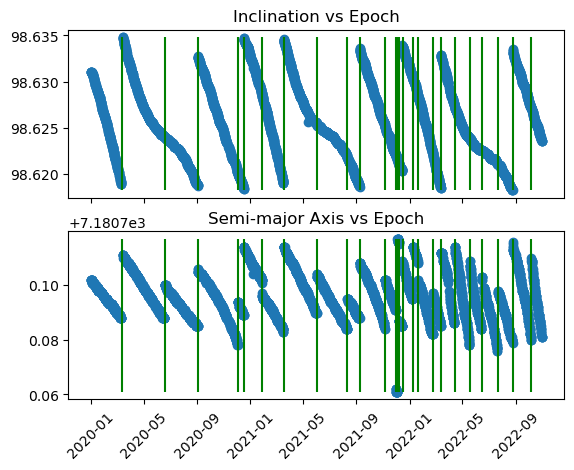

In [32]:
# plot each feature with timestamps of maneuvers marked
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, sharex=True)

x = data['EPOCH']
y1 = data['INCLINATION']
y2 = data['SEMIMAJOR_AXIS']
ax1.scatter(x, y1)
ax1.vlines(maneuvers, y1.min(), y1.max(), color='g')
ax1.set_title('Inclination vs Epoch')
ax2.scatter(x, y2)
ax2.vlines(maneuvers, y2.min(), y2.max(), color='g')
ax2.set_title('Semi-major Axis vs Epoch')
plt.xticks(rotation=45)

plt.show()

In [64]:
# explore maneuver detection using RF
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X = data.drop(columns=['MANEUVERED', 'EPOCH'])
y = data['MANEUVERED']
smote = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

clf = RandomForestClassifier(random_state=0)
clf.fit(X_resampled, y_resampled)
y_pred = clf.predict(X_test)

In [65]:
# # Try grid search
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer, confusion_matrix
# import numpy as np

# def cost(y_test, y_pred):
#     cm = confusion_matrix(y_test, y_pred)
#     cost_matrix = np.array(
#         [
#             [0,5],  # 5 gain for false positives
#             [100,0],  # 1 gain for false negatives
#         ]
#     )
#     return np.sum(cm * cost_matrix)

# # create param grid for grid search
# param_grid = {
#     'n_estimators': [i for i in range(100, 1100, 100)],
#     'criterion': ['gini', 'entropy', 'log_loss'],
#     'max_depth': [i for i in range(2, 20, 3)],
#     'class_weight': [None, 'balanced', 'balanced_subsample'],
#     'random_state': [0]
# }

# # create scorer from cost matrix
# cost_scorer = make_scorer(cost, greater_is_better=False)

# # Set up GridSearchCV with cross-validation
# grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=2, scoring=cost_scorer, n_jobs=-1, verbose=1)

# # Fit grid search to the training data
# grid_search.fit(X_train, y_train)

# # Print the best parameters and best cross-validation score
# print("Best Parameters:", grid_search.best_params_)
# print("Total Cost: ", cost(y_test, y_pred),"\n")
# print("Best Cross-Validation Accuracy:", grid_search.best_score_)

In [66]:
# output metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

def output_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    print(f"True Positive: {cm[1][1]}\n"
          f"False Positive: {cm[0][1]}\n" # labelled good when bad
          f"True Negative: {cm[0][0]}\n"
          f"False Negative: {cm[1][0]}\n" # labelled bad when good
          )

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
# Precision
precision = precision_score(y_test, y_pred)
# Recall
recall = recall_score(y_test, y_pred)
# F1-Score
f1 = f1_score(y_test, y_pred)
# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

print('Confusion Matrix:')
print(output_metrics(y_test, y_pred))
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1)
print('ROC AUC:', roc_auc)

Confusion Matrix:
True Positive: 1
False Positive: 38
True Negative: 867
False Negative: 5

None
Accuracy: 0.9527991218441273
Precision: 0.02564102564102564
Recall: 0.16666666666666666
F1-Score: 0.044444444444444446
ROC AUC: 0.5623388581952119
